***
# PYNQ Theremin
***

By: Ben Cumming, Ryan Greer and Alexandra Ligeti
***
***


## Introduction

This project aims to create a theremin by using an ultrasonic sensor to determine the distance of the musician's hand in order for different tones to be played.

Move your hand closer to the ultrasonic sensor to generate high frequency tones and further away from the sensor to generate lower frequency tones. As you move your hand, different tones will be heard as well as changing coloured lights from the LED. Figure 1 shows a high-level block diagram of our PYNQ Theremin design, showing the key hardware and software components:

<img src="block_diagram.png" height = "750" width = "750">

Figure 1: PYNQ Theremin High-Level Block Diagram

## Background
### Ultrasonic sensor

The ultrasonic sensor is used to detect the presence of a users hand and the distance the hand is away from the device. 
It uses a simple method:
* A pulse is transmitted from the ultrasonic sensor
* The pulse reaches the users hand and an echo pulse is returned back to the receiver
* The distance the users hand is away from the theremin is calculated by considering the time of flight

Time of flight = time taken between emission and reception of pulse

$Distance = \frac{1}{2}.t.v$

The theremin functions within a range of 0 cm to 40 cm, although the ultrasonic ranger has an operating range of up to 4 m usually.

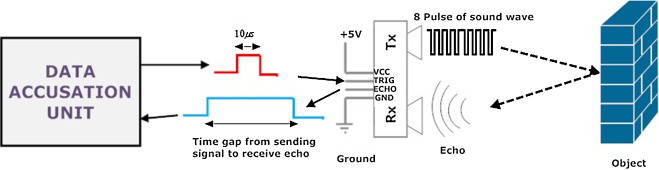

Figure 2: Displaying the basic operation of how an ultrasonic sensor functions [1]

### NCO

The NCO module is a timer that uses the overflow of an accumulator to address a look-up table, containing sine wave samples, and generate an output signal. The accumulator overflow is controlled by an adjustable increment value rather than just a single clock pulse. The step size which is the input to the NCO is the only changing variable, which is linked to the distance the user's hand is away from the sensor. Hence as the distance the users hand is from the device changes so to does the step size and thus the NCO sine wave responds accordingly to this change. 

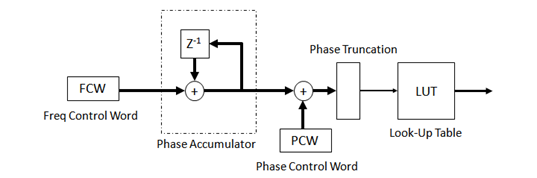

Figure 3: Highlighting the basic architecture of an NCO [2]


### Audio Play

The tone that sounds is dependant on the distance the hand is away from the sensor. The closer the hand is to the sensor, the higher the frequency and so the higher the pitch of the tone played. The tone is linked to the step size of the NCO, depending on the distance the sensor measures the step size adjusts accordinly to ensure different tones sound. The audio is output from the board using the ADAU1761 audio codec module by Analog Devices.

## Hardware Design - Brief Overview

The hardware consists of two designs incorporated into the Base Overlay provided by the PYNQ team. The two custom designs are the NCO, created with System Generator for DSP, and the ultrasonic ranger driver, created using VHDL and the IP Packager tool in Vivado. Figure 3 shows the Base Overlay in Vivado IP Integrator with our custom IP highlighted in pink:

<img src="base_ol.PNG">

Figure 4: PYNQ Theremin Overlay

We chose to incorporate our design into the Base Overlay so as to take advantage of the existing features and functionality in our design.

We could've added the GPIO IP to a completely new overlay and specified the constraints for the board peripherals, but it was deemed that time would be better spent enriching the functionality of our design, with the pre-built Base Overlay features, rather than "re-inventing the wheel", which is in the spirit of using PYNQ.

### Ultrasonic Ranger Driver

The ultrasonic ranger driver IP is shown zoomed in. We had to create a tristate buffer in the VHDL wrapper as this is not automatically inferred by specifying an "inout" port on a VHDL design entity within the block design [3]. The AXI-lite interface allows the user to specify the refresh rate of the ultrasonic sensor - there is a tradeoff between refresh rate and maximum range. The measured distance is continously updated and can be read from the AXI-lite interface.

<img src="usr_drv_zoom.png" height="500" width="500">

Figure 5: Ultrasonic Ranger Driver IP

### NCO

The NCO IP is shown zoomed in along with the audio codec control IP core which is part of the base overlay. The AXI-lite interface is used to specify the volume of each audio channel as well as the step size and an "enable" port.

<img src="nco_zoom.png" height="500" width="500">

Figure 6: NCO IP

## PYNQ Theremin Live Demo

Run the following cells:
- Connect the Grove ultrasonic ranger to PMODA, G1 using the PYNQ Grove adaptor
- Connect your headphones or a speaker via AUX to the "HP+MIC" port on the PYNQ board

***IMPORTANT:*
Although every effort has been made to make this safe on your hearing, the volume may still be very loud depending on your headphone configuration. The default volume and range of the volume slider has been set to a safe level based on our experience.**

### 1. Write the bitstream

In [ ]:
import pynq

from pynq.overlays.base import BaseOverlay

overlay = BaseOverlay("GP_B_overlay.bit")

### 2. Create MMIO instances
This is for reading and writing to the AXI-lite interface on the NCO (volume, step size, enable) and the ultrasonic ranger driver (refresh frequency and measured distance)

In [ ]:
# CREATE MMIO INSTANCES
from pynq import MMIO

# usr driver
base_addr_dist = overlay.ip_dict['usr_driver/distmm']['phys_addr']
addr_range_dist = overlay.ip_dict['usr_driver/distmm']['addr_range']
mmio_dist = MMIO(base_addr_dist, addr_range_dist)

base_addr_freq = overlay.ip_dict['usr_driver/refresh_freq']['phys_addr']
addr_range_freq = overlay.ip_dict['usr_driver/refresh_freq']['addr_range']
mmio_freq = MMIO(base_addr_freq, addr_range_freq)

# NCO
base_addr_nco = overlay.ip_dict['nco_processing']['phys_addr']
addr_range_nco = overlay.ip_dict['nco_processing']['addr_range']
mmio_nco = MMIO(base_addr_nco, addr_range_nco)

# instantiate audio codec IP
audio_codec_inst = overlay.audio_codec_ctrl_0

### 3. Setup class to describe theremin functionality
This class is only intended to be instantiated once. In fact, if you don't modify the code, it automatically deletes old versions if you try to re-instantiate it. This is purely for keeping the functions tidy.

Our theremin design uses Asyncio to handle multiple threads (and interrupts) in the software. This is necessary as we wish to have a dynamic system with multiple software operations occuring *concurrently*. These include widgets which update registers in the hardware as well as functions which handle interrupts from the peripherals (button). When the object is destroyed, these tasks are automatically cancelled so the processor does not get overloaded.

The functions are described below:
- **conv_fxp_uint** - Converts a fixed point value (input is a float type) into its unsigned integer interpretation assuming 24 bits in the fractional component.
- **get_step_size** - Convert a desired frequency into step size using: $μ = N \frac{f_d}{f_s}$, where $μ$ is the step size, $N$ is the NCO LUT depth, $f_d$ is the desired frequency and $f_s$ is the sampling frequency.
- **update_RGB_LED_colour** - Takes a distance, the user's hand is away from the sensor, and uses this to compute a corresponding red, green and blue intensity. These are used to control the duty cycles of the three LEDs on the RGB LEDs to give an LED colour fading effect as the user's hand moves towards and away from the sensor.
- **update_step_size_RGB_LEDs** - Reads the distance register from the ultrasonic ranger driver and if there's no error (i.e. a '-1' returned if the sensor does not have an appropriate refresh frequency) uses this to compute a step size for the NCO.
- **outwith_range_blinky** - Asyncio co-routine - used to blink LED 3 when the user's hand is outwith range of the sensor. Not actually enabled due to high CPU utilisation as other more important tasks are slowed down.
- **volume_slider** - Asyncio co-routine. Provides slider widget to control the audio volume [4].
- **usr_refresh_rate_slider** - Asyncio co-routine. Provides a slider to control the refresh frequency of the ultrasonic ranger - also displays the corresponding maximum range as this is inversely proportional to the refresh frequency.
- **resource_print** - Asyncio co-routine. Provides a button widget to output the current CPU utilisation [5].
- **theremin_on_off** - Asyncio co-routine. Checks if button0 has been pressed using an asyncronous interrupt. Switches the thermin on or off - i.e. audio off, sensor off... LED0 is also switched on or off to indicate the on/off status of the theremin.
- **bypass_routine** - Uses multi-threading to enable audio "bypass" function to be run at the same time as "update_step_size_RGB_LEDs" [4].
- **cancel_tasks** - should be executed before the theremin object has been detroyed. Deletes all Asyncio tasks.
- **start_theremin** - starts the theremin by setting up all Asyncio tasks.

In [ ]:
import math
import time
from time import sleep
import asyncio
import _thread
from pynq import DefaultIP
import ipywidgets as widgets

%gui asyncio

class theremin_functions():
    def __init__(self):
        None
        
    def conv_fxp_uint(self,value_in):
        # assumes 24 fractional bits - function only used to set step size in NCO
        return int(value_in * 2**24)

    def get_step_size(self,desired_freq):
        sys_clock_freq = 100000000
        nco_clock_freq = 1024
        nco_lut_depth = 256
        return self.conv_fxp_uint(nco_lut_depth * desired_freq / (sys_clock_freq / nco_clock_freq))

class theremin(theremin_functions):
    def __init__(self):
        
        # default ultrasonic ranger refresh frequency
        self.frequency = 100
        mmio_freq.write(0x00,self.frequency)

        # default NCO settings
        mmio_nco.write(0x00,1)                       # left volume
        mmio_nco.write(0x04,1)                       # right volume
        mmio_nco.write(0x08,1)                       # write 1 to select NCO, 0 to select input audio jack
        mmio_nco.write(0x0C,self.get_step_size(800)) # step size computed in correct fixed point unsigned integer format
        
        self.tasks = []                              # task list
        
        self.theremin_on = 1                         # 1 for theremin on or 0 for theremin off
        
        self.outwith_range = 0                       # indicate if we are outwith operating range of sensor
        
        self.max_dist = 400                          # maximum distance the theremin may be operated from
        
    def update_RGB_LED_colour(self,dist):
        
        pi = 3.141593
        tau = 0.01
        
        # 400 mm is maximum range
        if(dist <= self.max_dist):
            trig_arg = dist/self.max_dist * 6/3*pi

            red_intensity = math.cos(trig_arg)
            green_intensity = math.cos(trig_arg - 2/3*pi)
            blue_intensity = math.cos(trig_arg + 2/3*pi)
    
            if(red_intensity > 0):
                overlay.rgbleds[4].write(4)
                overlay.rgbleds[5].write(4)
                sleep(0.33*tau*red_intensity)
            if(green_intensity > 0):
                overlay.rgbleds[4].write(2)
                overlay.rgbleds[5].write(2)
                sleep(0.33*tau*green_intensity)
            if(blue_intensity > 0):
                overlay.rgbleds[4].write(1)
                overlay.rgbleds[5].write(1)
                sleep(0.33*tau*blue_intensity)
                   
    def update_step_size_RGB_LEDs(self,sound_time):
                
        start_time = time.time()
        while(time.time() < (start_time + sound_time)):
            if(self.theremin_on == 1):
                dist = mmio_dist.read(0x00)
                if(dist != 4294967395):                   # i.e. no error from usr driver module
                    tone_freq = -3.5*dist+1500
                    
                if(dist <= self.max_dist):
                    mmio_nco.write(0x0C,self.get_step_size(tone_freq))
                else:
                    # OUTWITH DISTANCE RANGE
                    mmio_nco.write(0x0C,self.get_step_size(0))
                    
                if(dist > self.max_dist):
                    self.outwith_range = 1
                else:
                    self.outwith_range = 0
                    
                self.update_RGB_LED_colour(dist)
                
    @asyncio.coroutine
    def outwith_range_blinky(self):
        overlay.leds[3].off()
        while(1):
            if(self.outwith_range == 1):
                overlay.leds[3].toggle()
                yield from asyncio.sleep(0.5)
                overlay.leds[3].toggle()
                yield from asyncio.sleep(0.5)
            
    @asyncio.coroutine
    def volume_slider(self,sound_time):
    
        volume_widget = widgets.FloatSlider(
            value=0.0078125,
            min=0,
            #max=1,
            max=0.03125,
            step=0.0078125,
            #description='Volume Control',
            description='',
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='.3f',
        )
        
        display(widgets.Label(value="Volume Control: "))
        display(volume_widget)
        
        start_time = time.time()
        while(time.time() < (start_time + sound_time)):
            if(self.theremin_on == 1):
                mmio_nco.write(0x00,int(volume_widget.value*128))
                mmio_nco.write(0x04,int(volume_widget.value*128))
            yield from asyncio.sleep(0.5)
        
    @asyncio.coroutine
    def usr_refresh_rate_slider(self,sound_time):
    
        # slider test
        frequency_widget = widgets.FloatSlider(
            value=100,
            min=0,
            max=500,
            step=10,
            #description='Ultrasonic Ranger Refresh Rate Control',
            description='',
            disabled=False,
            continuous_update=True,
            orientation='horizontal',
            readout=True,
            readout_format='.3f',
        )
        
        display(widgets.Label(value="Ultrasonic Ranger Refresh Rate Control: "))
        display(frequency_widget)
        
        max_range_label = widgets.Label(value= "Ultrasonic Ranger Max Range: " + str(0.5/frequency_widget.value*34000) + " cm ; there is a trade-off between refresh frequency and maximum range")
        display(max_range_label)        
        
        start_time = time.time()
        while(time.time() < (start_time + sound_time)):
            if(self.theremin_on == 1):
                mmio_freq.write(0x00,int(frequency_widget.value))
                if(frequency_widget.value != 0.0):
                    max_range = 0.5/frequency_widget.value*34000
                    max_range_label.value = "Ultrasonic Ranger Max Range: " + str(max_range) + " cm ; there is a trade-off between refresh frequency and maximum range"
                    # set max distance equal to this max distance if it is less than 400mm due to increasing the refresh frequency too high
                    if(max_range < 40):
                        self.max_dist = max_range * 10
                    else:
                        self.max_dist = 400
                
                else:
                    max_range_label.value = "Ultrasonic Ranger Max Range: " + "Sensor Off!"                    
            yield from asyncio.sleep(0.5)
            
    @asyncio.coroutine
    def resource_print(self):
        
        usage_info = widgets.Label(value = "The system has high resource usage (usually 100%). Wait until the audio stops and click to see what happens!")
        display(usage_info)
        
        usage_label = widgets.Label(value = "CPU usage: ")
        display(usage_label)
        
        usage_btn = widgets.Button(description = "print_usage")
        display(usage_btn)
        
        def get_usage(button_click_arg):
            import psutil

            last_idle = [c.idle for c in psutil.cpu_times(percpu=True)]
            sleep(0.5)
            next_idle = [c.idle for c in psutil.cpu_times(percpu=True)]
            usage = [(1-(c2-c1)/3) * 100 for c1,c2 in zip(last_idle, next_idle)]
            usage_label.value = "CPU usage: " + str(usage[1]) + "%"
        
        usage_btn.on_click(get_usage)
        
        while(1):
            yield from asyncio.sleep(0.5)            
            
    @asyncio.coroutine
    def theremin_on_off(self):
        # button 0 used to switch theremin on or off - LED 0 used to indicate this
        overlay.leds[0].on()
        
        while(1):
            yield from overlay.buttons[0].wait_for_value_async(1)
            
            if(overlay.buttons[0].read()):
                yield from asyncio.sleep(0.5)                  # button debouncing                    
                overlay.leds[0].toggle()
                    
                if(self.theremin_on == 0):
                    self.theremin_on = 1
                else:
                    self.theremin_on = 0
                    mmio_freq.write(0x00,0)                   # ultrasonic ranger off
                    
            if(self.theremin_on == 0):
                overlay.rgbleds[4].write(0)                   # RGB LEDs off
                overlay.rgbleds[5].write(0)
                mmio_nco.write(0x00,0)                        # NCO off
                mmio_nco.write(0x04,0)                        # NCO off  
                
    @asyncio.coroutine
    def bypass_routine(self,sound_time):    
        # ref - audio example
        try:
            _thread.start_new_thread(audio_codec_inst.bypass, (sound_time,))
            _thread.start_new_thread(self.update_step_size_RGB_LEDs, (sound_time,))
                
        except Exception:
            import traceback
            print(traceback.format_exc())
                
    def cancel_tasks(self):
        # delete tasks if they already exist - ref: stack overflow, https://stackoverflow.com/questions/9390126/pythonic-way-to-check-if-something-exists
        try:
            self.tasks
        except:
            None
        else:
            [t.cancel() for t in self.tasks]
            
    def start_theremin(self,sound_time):
            
        self.tasks.append(asyncio.ensure_future(self.bypass_routine(sound_time)))
        self.tasks.append(asyncio.ensure_future(self.volume_slider(sound_time)))
        self.tasks.append(asyncio.ensure_future(self.usr_refresh_rate_slider(sound_time)))
        self.tasks.append(asyncio.ensure_future(self.theremin_on_off()))
        self.tasks.append(asyncio.ensure_future(self.resource_print()))
        # could not include the below task as there is not enough CPU capacity
        #self.tasks.append(asyncio.ensure_future(self.outwith_range_blinky()))
        
print("...done!")

### 4. Run below cell to start the theremin
Change the time the theremin runs for (**maximum 60s** at a time). Remember to re-run the cell after this time!

Button0 switches the theremin on or off; all other functionality can be seen from the widgets

In [ ]:
# ONLY CHANGE THIS LINE #
audio_time = 30
#########################

try:
    theremin_inst
except:
    None
else:
    theremin_inst.cancel_tasks()   # must cancel old tasks otherwise they remain active and cause issues...
    del theremin_inst              # delete old instance of class - only want one instance at a time

theremin_inst = theremin()
theremin_inst.start_theremin(audio_time)

## References

- [1] https://www.researchgate.net/figure/Working-principle-of-an-ultrasonic-sensor_fig1_304822025
- [2] https://dsp.stackexchange.com/questions/37803/numerically-controlled-oscillator-nco-for-phasor-implementation
- [3] https://www.xilinx.com/support/answers/1374.html
- [4] Louise Crockett - Audio Example
- [5] http://www.pynq.io/